# DNN 모델

- 미리 정리된 학습데이터를 사용
- cross validation 적용
- dnn 적용
- ensemble 적용

## todo
- model class 완성
    - cross validation 코드를 class에 포함시키자.
- 최적 hyper parameter 찾기
    - epoch, layers, units 등을 조절해 보자
- ensemble 구성하자
    - 최종 hyper parameter 기반으로 ensemble 구성하자

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import KFold
import time
import matplotlib.pyplot as plt

## model class

In [2]:
class Model:

    def __init__(self, sess, name):
        self.sess = sess
        self.name = name

    def build_net(self, features=8, layers=4, units=100):
        with tf.variable_scope(self.name):
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            self.training = tf.placeholder(tf.bool)

            # input place holders
            self.X = tf.placeholder(tf.float32, [None, features])
            self.Y = tf.placeholder(tf.float32, [None, 1])
            
            initializer = tf.contrib.layers.xavier_initializer()
            
            hiddenLayer = self.X
            for i in range(layers):
                hiddenLayer = tf.layers.dense(inputs=hiddenLayer, units=units, activation=tf.nn.relu, kernel_initializer=initializer)
                hiddenLayer = tf.layers.dropout(inputs=hiddenLayer, rate=0.5, training=self.training)
                
            self.logits = tf.layers.dense(inputs=hiddenLayer, units=1)
        
        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)

        self.prediction = tf.round(tf.nn.sigmoid(self.logits))
        correct_prediction = tf.equal(self.prediction, self.Y)
        self.correct_count = tf.reduce_sum(tf.cast(correct_prediction, tf.float32))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, training=False):
        return self.sess.run(self.prediction, feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy, feed_dict={self.X: x_test, self.Y: y_test, self.training: training})
    
    def train(self, x_data, y_data, training=True):
        return self.sess.run([self.cost, self.optimizer], feed_dict={self.X: x_data, self.Y: y_data, self.training: training})

In [3]:
train = pd.read_csv('train_01.csv')
train.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,0,3,0,1.0,0.0,2.0,0,0,0.4
1,1,1,1,3.0,2.0,0.8,1,2,0.4
2,1,3,1,1.0,0.0,2.0,0,1,0.0
3,1,1,1,2.0,2.0,0.8,0,2,0.4
4,0,3,0,2.0,0.0,2.0,0,0,0.0


In [4]:
train_y = train['Survived']
train_x = train.drop('Survived', axis=1)

In [5]:
train_y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [6]:
type(train_y)

pandas.core.series.Series

In [7]:
train_x.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,3,0,1.0,0.0,2.0,0,0,0.4
1,1,1,3.0,2.0,0.8,1,2,0.4
2,3,1,1.0,0.0,2.0,0,1,0.0
3,1,1,2.0,2.0,0.8,0,2,0.4
4,3,0,2.0,0.0,2.0,0,0,0.0


In [8]:
# hyper parameters
learning_rate = 0.001
training_epochs = 200
batch_size = 100

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

## cross validation 으로 hyper parameter 결정

In [9]:
foldCount = 10
k_fold = KFold(foldCount)

models_v = []
for m in range(foldCount):
    models_v.append(Model(sess, "model_v" + str(m)))
    models_v[m].build_net(features=8, layers=4, units=100)

sess.run(tf.global_variables_initializer())

start_time = time.time()

valid_acc = []
idx = 0;
for train_indices, valid_indices in k_fold.split(train):
    #print('Train: %s \n| test: %s\n' % (train_indices, test_indices))
    iter = 0
    x_collect = []
    train_acc_collect = []
    valid_acc_collect = []

    m = models_v[idx]
    
    start_time_k = time.time()
    
    X_train = train_x.iloc[train_indices]
    Y_train = train_y.iloc[train_indices]
    X_valid = train_x.iloc[valid_indices]
    Y_valid = train_y.iloc[valid_indices]
    
    Y_train_=Y_train.values.reshape([-1,1])
    Y_valid_ = Y_valid.values.reshape([-1,1])
    
    for i in range(training_epochs):
        c, _ = m.train(X_train.values, Y_train_)
        accuracy_t = m.get_accuracy(X_train.values, Y_train_)
        accuracy_v = m.get_accuracy(X_valid.values, Y_valid_)
        train_acc_collect.append(accuracy_t)
        valid_acc_collect.append(accuracy_v)
        x_collect.append(iter)
        iter=iter+1

    accuracy = m.get_accuracy(X_valid.values, Y_valid_)
    print("accuracy=%.2f" % accuracy, " %.2f seconds" % (time.time() - start_time_k))
    valid_acc.append(accuracy)
    
    #plt.plot(x_collect, train_acc_collect, "r--")
    #plt.plot(x_collect, valid_acc_collect, "g--")
    #plt.show()
    
    ++idx

print(" %.2f seconds" % (time.time() - start_time))

accuracy=0.81  2.31 seconds
accuracy=0.89  2.22 seconds
accuracy=0.75  2.19 seconds
accuracy=0.85  2.54 seconds
accuracy=0.88  2.30 seconds
accuracy=0.88  2.20 seconds
accuracy=0.82  2.23 seconds
accuracy=0.87  2.17 seconds
accuracy=0.90  2.18 seconds
accuracy=0.88  2.19 seconds
 22.53 seconds


In [10]:
valid_acc

[0.81111109,
 0.88764048,
 0.75280899,
 0.85393256,
 0.87640452,
 0.87640452,
 0.8202247,
 0.86516851,
 0.89887643,
 0.87640452]

In [11]:
round(np.mean(valid_acc) * 100, 2)

85.189999999999998

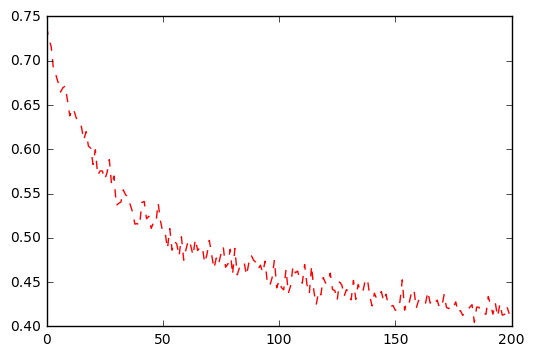

In [12]:
model = Model(sess, "model")
model.build_net(features=8, layers=4, units=100)

sess.run(tf.global_variables_initializer())

cost_collect = []
for i in range(training_epochs):
    c, _ = model.train(train_x.values, train_y.values.reshape([-1,1]))
    train_acc_collect.append(accuracy)
    cost_collect.append(c)

plt.plot(cost_collect, "r--")
plt.show() 

In [13]:
accuracy = model.get_accuracy(train_x.values, train_y.values.reshape([-1,1]))
print("accuracy=%.2f" % accuracy)

accuracy=0.85


In [14]:
test = pd.read_csv("test_01.csv")
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,892,3,0,2.0,0.0,2.0,2,0,0.0
1,893,3,1,3.0,0.0,2.0,0,2,0.4
2,894,2,0,3.0,0.0,2.0,2,0,0.0
3,895,3,0,2.0,0.0,2.0,0,0,0.0
4,896,3,1,1.0,0.0,2.0,0,2,0.8


In [15]:
test_x = test.drop("PassengerId", axis=1)
test_x.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,3,0,2.0,0.0,2.0,2,0,0.0
1,3,1,3.0,0.0,2.0,0,2,0.4
2,2,0,3.0,0.0,2.0,2,0,0.0
3,3,0,2.0,0.0,2.0,0,0,0.0
4,3,1,1.0,0.0,2.0,0,2,0.8


In [16]:
result = model.predict(test_x.values)
result = result.reshape([-1]).astype(int)

submission = pd.DataFrame({"PassengerId": test["PassengerId"], "Survived":result})
submission.head()

submission.to_csv('submission.csv', index=False)